In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from currency_converter import CurrencyConverter
sns.set()

In [3]:
rio = pd.read_csv('../classifying/classified_rio.csv').rename(columns={'r$_pmo':'price'})
mumbai = pd.read_csv('../classifying/classified_mumbai.csv')
hyderabad = pd.read_csv('../classifying/classified_hyderabad.csv')

rent_index = pd.read_csv('../classifying/city_rent_index.csv')
rent_index.dropna(inplace=True)

### Standardizing Prices

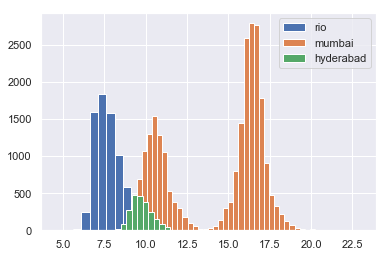

In [4]:
rio['price'].apply(np.log).hist(bins=20, label='rio')
mumbai['price'].apply(np.log).hist(bins=50, label='mumbai')
hyderabad['price'].apply(np.log).hist(bins=10, label='hyderabad')
plt.legend();

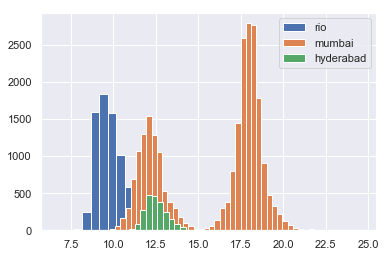

In [5]:
# CITY RENT INDEX ADJUSTMENT

rio_factor = 100/rent_index[rent_index['City']=='Rio de Janeiro, Brazil']['Rent Index'].values[0]
mumbai_factor = 100/rent_index[rent_index['City']=='Mumbai, India']['Rent Index'].values[0]
hyderabad_factor = 100/rent_index[rent_index['City']=='Hyderabad, India']['Rent Index'].values[0]

rio['price'] = rio_factor*rio['price']
mumbai['price'] = mumbai_factor*mumbai['price']
hyderabad['price'] = hyderabad_factor*hyderabad['price']
mumbai.dropna(subset=['price'], inplace=True)
hyderabad.dropna(subset=['price'], inplace=True)

rio['price'].apply(np.log).hist(bins=20, label='rio')
mumbai['price'].apply(np.log).hist(bins=50, label='mumbai')
hyderabad['price'].apply(np.log).hist(bins=10, label='hyderabad')
plt.legend();

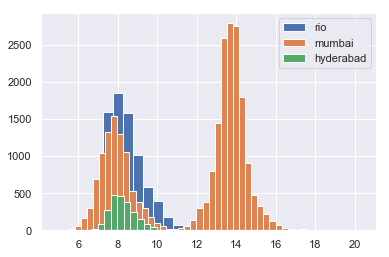

In [6]:
# CONVERT TO USD

cc = CurrencyConverter()
def ConvINR(x):
    return round(cc.convert(x, 'INR', 'USD'))
def ConvBRL(x):
    return round(cc.convert(x, 'BRL', 'USD'))

rio['price'] = rio['price'].apply(ConvBRL)
mumbai['price'] = mumbai['price'].apply(ConvINR)
hyderabad['price'] = hyderabad['price'].apply(ConvINR)

rio['price'].apply(np.log).hist(bins=20, label='rio')
mumbai['price'].apply(np.log).hist(bins=50, label='mumbai')
hyderabad['price'].apply(np.log).hist(bins=10, label='hyderabad')
plt.legend();

## Bootstrapping

In [181]:
def bootstrap(df):
    print(df.isna().sum().sum(), 'nans dropped')
    df.dropna(inplace=True)
    out = pd.concat([df, df[df['class'] == 1].sample(
                     df['class'].value_counts()[0] - df['class'].value_counts()[1],
                     replace = True)]).reset_index().drop(columns='index')
    print(len(out)-len(df), 'rows added')
    return out

In [182]:

rio_boot = bootstrap(rio)
mumbai_boot = bootstrap(mumbai)
hyderabad_boot = bootstrap(hyderabad)

2319 nans dropped
5543 rows added
991 nans dropped
22503 rows added
821 nans dropped
1464 rows added


## modeling

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [16]:
def xcity_pred(train, test):
    
    
    if train.equals(test):
        x = train[['price']]
        y = train['class']
        x_train, x_test, y_train, y_test = train_test_split(x, y, )
    else:
        x_train = train[['price']]
        y_train = train['class']
        x_test = test[['price']]
        y_test = test['class']
        
    
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(x_train, y_train)
    print('train:', rf.score(x_train, y_train), '| test:', rf.score(x_test, y_test))
    

In [17]:
cities = {'rio': rio, 'mumbai': mumbai, 'hyderabad': hyderabad}

for train_name, train_df in cities.items():
    for test_name, test_df in cities.items():
        print(f'train: {train_name} | test: {test_name}')
        xcity_pred(train_df, test_df)
        print('')

train: rio | test: rio
train: 0.7327902707664066 | test: 0.7105987611837578

train: rio | test: mumbai
train: 0.7286181380141111 | test: 0.4997651379280895

train: rio | test: hyderabad
train: 0.7281879194630873 | test: 0.5

train: mumbai | test: rio
train: 0.8567768383294901 | test: 0.49414902770607466

train: mumbai | test: mumbai
train: 0.8574031371879182 | test: 0.83995217354172

train: mumbai | test: hyderabad
train: 0.8566914339397045 | test: 0.4066225165562914

train: hyderabad | test: rio
train: 0.7072847682119205 | test: 0.4755635863018413

train: hyderabad | test: mumbai
train: 0.7072847682119205 | test: 0.48889742932786745

train: hyderabad | test: hyderabad
train: 0.7041942604856513 | test: 0.7033112582781457

